# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

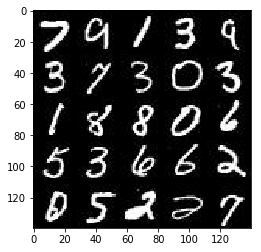

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

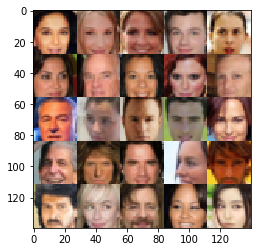

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    fake = tf.placeholder(tf.float32, [None, z_dim])
    learn_rate = tf.placeholder(tf.float32)

    return real, fake, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope("discriminator", reuse=reuse):
        #Shape starts as 28*28*3
        x1 = tf.layers.conv2d(inputs=images, 
                              filters=64, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Apply leaky relu
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.9)
        #Shape now is: 14*14*64
        
        x2 = tf.layers.conv2d(inputs=x1, 
                              filters=128, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Use batch normalization.
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, x2*alpha)
        x2 = tf.nn.dropout(x2, 0.9)
        #Shape is now: 7*7*128
        
        x3 = tf.layers.conv2d(inputs=x2, 
                              filters=256, 
                              kernel_size=(4, 4), 
                              strides=(2, 2), 
                              padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, x3 * alpha)
        #Shape is now: 4*4*256
        
        #Flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.contrib.layers.fully_connected(flat, 1, activation_fn=None)
        
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        #Reshape to start deconvolutions.
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.contrib.layers.dropout(x1, 0.5, is_training=is_train)
        
        x2 = tf.layers.conv2d_transpose(inputs=x1, 
                                        filters=256, 
                                        kernel_size=(4, 4), 
                                        strides=(2,2), 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        x2 = tf.contrib.layers.dropout(x2, 0.5, is_training=is_train)
        #Shape is 8*8*256
        
        x3 = tf.layers.conv2d_transpose(inputs=x2,
                                        filters=128,
                                        kernel_size=(4, 4),
                                        strides=(2, 2),
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        x3 = tf.contrib.layers.dropout(x3, 0.5, is_training=is_train)
        #Shape is now 16*16*128
        
        x4 = tf.layers.conv2d_transpose(inputs=x3, 
                                        filters=64, 
                                        kernel_size=(5, 5), 
                                        strides=(2, 2), 
                                        padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        #Shape is now 32*32*3
        #Final layer to add depth.
        logits = tf.layers.conv2d_transpose(inputs=x4, 
                                            filters=out_channel_dim, 
                                            kernel_size=(5, 5), 
                                            strides=(1, 1), 
                                            padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        logits = tf.tanh(logits)
        
        output = tf.image.resize_images(logits, (28, 28))
        #Shape is now 28*28*3

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_logits_real = discriminator(input_real)
    d_logits_fake = discriminator(g_output, reuse=True)
    
    smooth_val = 0.1
    smooth_factor = (1 - smooth_val)
    
    d_loss_real = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * smooth_factor))
    
    d_loss_fake = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)))
    
    d_loss= d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(
                     tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=disc_vars)
        gen_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=gen_vars)
    
    return disc_optimizer, gen_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_fake, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_fake, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                #Normalize the image data for better convergence with Tanh.
                batch_images = batch_images * 2
                
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run Generator optimizer.
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                _ = sess.run(g_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                #Run Optimizer
                _ = sess.run(d_train_opt, feed_dict={ input_real: batch_images, input_fake: batch_z, learn_rate: learning_rate })
                
                if(steps % 10 == 0):
                    train_loss_d = d_loss.eval({input_real: batch_images, input_fake: batch_z })
                    train_loss_g = g_loss.eval({input_fake: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if(steps % 100 == 0):
                    show_generator_output(sess, 9, input_fake, data_shape[3], data_image_mode)
            
            saver.save(sess, './checkpoints/checkpoint.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0640... Generator Loss: 1.1565
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.5919
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 0.9363
Epoch 1/2... Discriminator Loss: 1.7947... Generator Loss: 1.9639
Epoch 1/2... Discriminator Loss: 2.0547... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 3.9176... Generator Loss: 0.2268
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 1.9173
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 1.5402
Epoch 1/2... Discriminator Loss: 0.8279... Generator Loss: 2.3315


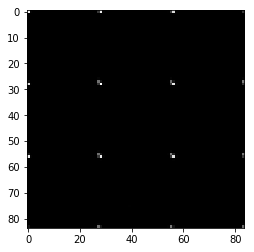

Epoch 1/2... Discriminator Loss: 2.4196... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 2.3452... Generator Loss: 1.6236
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.3740... Generator Loss: 1.3159
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 2.1946
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.4354
Epoch 1/2... Discriminator Loss: 1.6331... Generator Loss: 0.8526
Epoch 1/2... Discriminator Loss: 1.6738... Generator Loss: 1.2686
Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 1.9355
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 1.5515


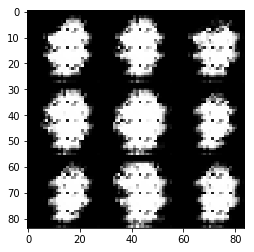

Epoch 1/2... Discriminator Loss: 1.5949... Generator Loss: 1.8163
Epoch 1/2... Discriminator Loss: 1.2048... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 1.4662
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 0.9067... Generator Loss: 1.6895
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 1.2146... Generator Loss: 1.2338
Epoch 1/2... Discriminator Loss: 1.2737... Generator Loss: 1.1600
Epoch 1/2... Discriminator Loss: 1.4039... Generator Loss: 0.8446


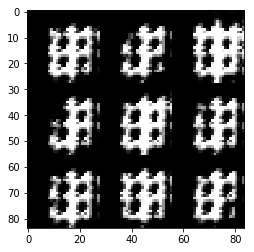

Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 2.5444
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 0.9790
Epoch 1/2... Discriminator Loss: 1.3827... Generator Loss: 1.0900
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 1.5700
Epoch 1/2... Discriminator Loss: 1.3032... Generator Loss: 1.1574
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 1.1627
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 1.2013
Epoch 1/2... Discriminator Loss: 1.2831... Generator Loss: 1.2383
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 1.0409
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 1.4723


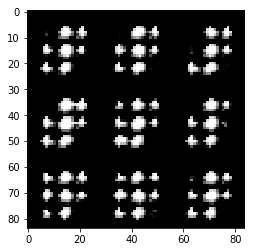

Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 0.9525... Generator Loss: 1.5102
Epoch 1/2... Discriminator Loss: 1.0288... Generator Loss: 1.8624
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.6118
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 1.4376... Generator Loss: 1.4333
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 1.1424
Epoch 1/2... Discriminator Loss: 1.6116... Generator Loss: 1.2848
Epoch 1/2... Discriminator Loss: 1.2392... Generator Loss: 1.2394


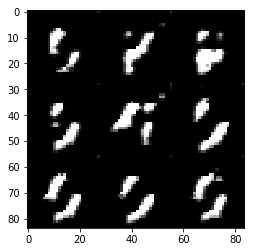

Epoch 1/2... Discriminator Loss: 1.3053... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.7803... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 1.0621
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 1.1925
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 1.0778
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.2314
Epoch 1/2... Discriminator Loss: 1.3461... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 1.3672


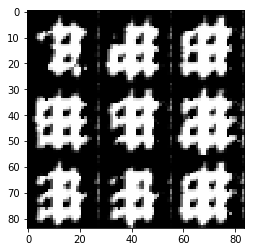

Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 1.8765
Epoch 1/2... Discriminator Loss: 0.8942... Generator Loss: 1.4600
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 1.4100
Epoch 1/2... Discriminator Loss: 1.4846... Generator Loss: 1.3517
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 1.2011
Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 1.2821
Epoch 1/2... Discriminator Loss: 1.1603... Generator Loss: 1.0983
Epoch 1/2... Discriminator Loss: 1.3260... Generator Loss: 1.0640


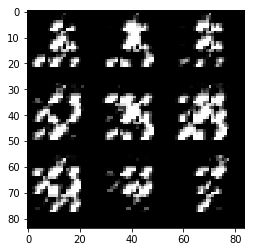

Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 1.2431
Epoch 1/2... Discriminator Loss: 1.0699... Generator Loss: 1.4069
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.2520
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.1905
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 1.2379
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 1.4403
Epoch 1/2... Discriminator Loss: 1.5704... Generator Loss: 0.9729
Epoch 1/2... Discriminator Loss: 1.5721... Generator Loss: 1.0080
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.8829
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 1.1232


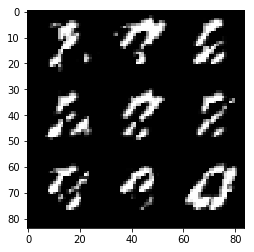

Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 1.1892
Epoch 1/2... Discriminator Loss: 1.5114... Generator Loss: 0.9670
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 1.4136... Generator Loss: 1.0730
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.4657... Generator Loss: 0.8789
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 1.2368
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 1.0907
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 1.0940
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 1.0316


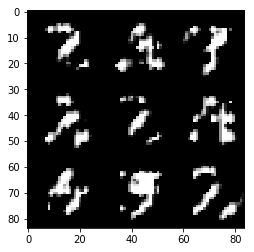

Epoch 1/2... Discriminator Loss: 1.2783... Generator Loss: 1.1520
Epoch 1/2... Discriminator Loss: 1.2886... Generator Loss: 1.2654
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.2857
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 1.4535... Generator Loss: 0.9072
Epoch 1/2... Discriminator Loss: 1.5100... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.9619
Epoch 1/2... Discriminator Loss: 0.9637... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 0.9638


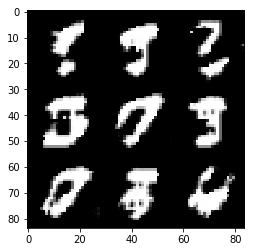

Epoch 1/2... Discriminator Loss: 1.5104... Generator Loss: 0.9367
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 1.2141
Epoch 1/2... Discriminator Loss: 0.9692... Generator Loss: 1.2411
Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 1.3652
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 1.2925
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.4025
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.3470
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 1.1914
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 1.0640


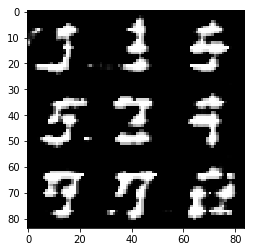

Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.2561... Generator Loss: 1.2091
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 1.1340
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 1.5029
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.6401
Epoch 1/2... Discriminator Loss: 1.0433... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 1.2640
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 1.1799... Generator Loss: 1.2395


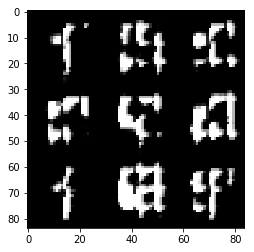

Epoch 1/2... Discriminator Loss: 1.2149... Generator Loss: 1.4017
Epoch 1/2... Discriminator Loss: 1.1589... Generator Loss: 1.1990
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.0433
Epoch 1/2... Discriminator Loss: 1.1070... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 1.1352
Epoch 1/2... Discriminator Loss: 1.5679... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.2247... Generator Loss: 1.0408
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 1.1143
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 1.2121


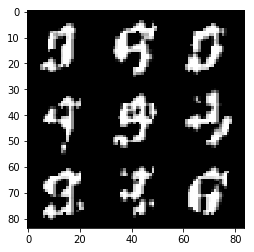

Epoch 1/2... Discriminator Loss: 1.4971... Generator Loss: 1.2855
Epoch 1/2... Discriminator Loss: 1.2988... Generator Loss: 0.9500
Epoch 1/2... Discriminator Loss: 1.2420... Generator Loss: 1.1617
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 1.1962
Epoch 1/2... Discriminator Loss: 1.1269... Generator Loss: 1.1048
Epoch 1/2... Discriminator Loss: 1.1196... Generator Loss: 1.1292
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 1.0444


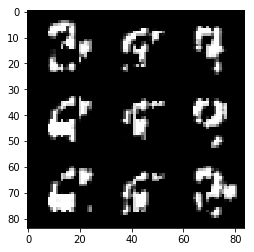

Epoch 1/2... Discriminator Loss: 1.1583... Generator Loss: 1.1815
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 1.4940
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 1.0941
Epoch 1/2... Discriminator Loss: 1.2999... Generator Loss: 1.1065
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 1.0532
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 1.1952
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.3252
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 1.1337
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 1.2580
Epoch 1/2... Discriminator Loss: 1.1483... Generator Loss: 1.0971


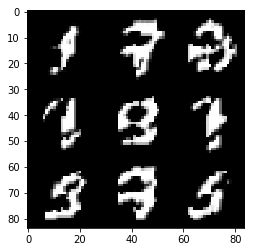

Epoch 1/2... Discriminator Loss: 1.0370... Generator Loss: 1.3648
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 1.0590
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 1.2760
Epoch 1/2... Discriminator Loss: 1.1460... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.2492
Epoch 1/2... Discriminator Loss: 0.9854... Generator Loss: 1.2284
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.4996
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 1.3020
Epoch 1/2... Discriminator Loss: 1.2642... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 1.1200


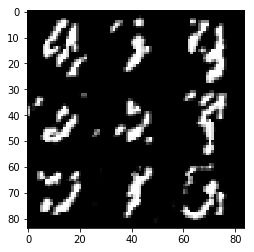

Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.1572
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 1.2703
Epoch 1/2... Discriminator Loss: 1.2134... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 1.1727... Generator Loss: 1.2872
Epoch 1/2... Discriminator Loss: 1.1143... Generator Loss: 1.0452
Epoch 1/2... Discriminator Loss: 1.1183... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 1.1891
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 1.3163
Epoch 1/2... Discriminator Loss: 1.0195... Generator Loss: 1.2140
Epoch 1/2... Discriminator Loss: 1.0841... Generator Loss: 1.2688


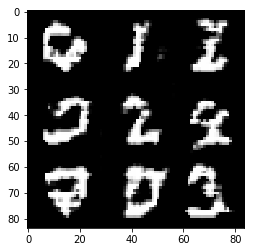

Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 1.3298
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 1.3862
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 1.1427
Epoch 1/2... Discriminator Loss: 1.1240... Generator Loss: 1.2689
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 1.2790
Epoch 1/2... Discriminator Loss: 1.0590... Generator Loss: 1.3422
Epoch 1/2... Discriminator Loss: 1.0412... Generator Loss: 1.1697
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 1.3051
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.9825
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 1.2277


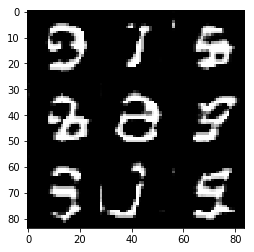

Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 1.1002
Epoch 1/2... Discriminator Loss: 1.2497... Generator Loss: 1.2263
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 1.2541
Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 1.2114
Epoch 1/2... Discriminator Loss: 1.1826... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 1.2360
Epoch 2/2... Discriminator Loss: 1.0883... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 1.1916
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 1.1379


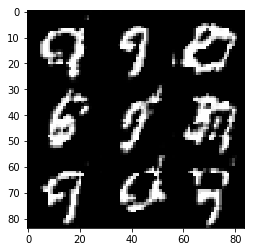

Epoch 2/2... Discriminator Loss: 1.2214... Generator Loss: 1.1612
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 1.0877
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 1.1302
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 1.0293
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 1.3476
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 1.3128
Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 1.0700
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 1.2913
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 1.2405


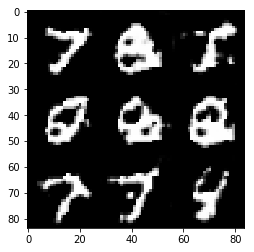

Epoch 2/2... Discriminator Loss: 1.1145... Generator Loss: 1.2601
Epoch 2/2... Discriminator Loss: 0.9651... Generator Loss: 1.0983
Epoch 2/2... Discriminator Loss: 1.0569... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 1.1815
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 1.3686
Epoch 2/2... Discriminator Loss: 1.2030... Generator Loss: 1.1108
Epoch 2/2... Discriminator Loss: 1.2029... Generator Loss: 1.1709
Epoch 2/2... Discriminator Loss: 1.0675... Generator Loss: 1.3540
Epoch 2/2... Discriminator Loss: 0.9865... Generator Loss: 1.4948
Epoch 2/2... Discriminator Loss: 1.1366... Generator Loss: 1.1920


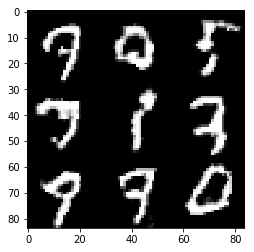

Epoch 2/2... Discriminator Loss: 1.0674... Generator Loss: 1.3353
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.2295
Epoch 2/2... Discriminator Loss: 1.0773... Generator Loss: 1.1812
Epoch 2/2... Discriminator Loss: 1.0362... Generator Loss: 1.1991
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.2434
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 1.3209
Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 1.1477
Epoch 2/2... Discriminator Loss: 1.0639... Generator Loss: 1.1253
Epoch 2/2... Discriminator Loss: 1.0651... Generator Loss: 1.2290
Epoch 2/2... Discriminator Loss: 1.0983... Generator Loss: 1.2142


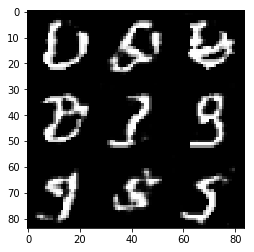

Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.2290
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 0.9794
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 1.1818
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 1.1408
Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 1.3480
Epoch 2/2... Discriminator Loss: 1.1119... Generator Loss: 1.2613
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.1788
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 0.9556
Epoch 2/2... Discriminator Loss: 0.9719... Generator Loss: 1.2716
Epoch 2/2... Discriminator Loss: 1.0089... Generator Loss: 1.4543


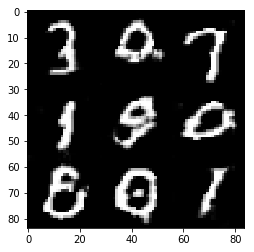

Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 1.1923
Epoch 2/2... Discriminator Loss: 1.1023... Generator Loss: 1.2823
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 0.9809... Generator Loss: 1.3483
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 1.1493
Epoch 2/2... Discriminator Loss: 1.0762... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 1.2696... Generator Loss: 0.9317
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.0520
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.1894


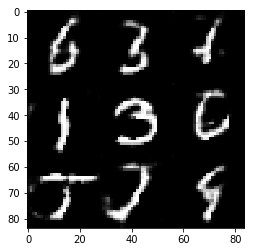

Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 1.2643
Epoch 2/2... Discriminator Loss: 1.0733... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 1.5252
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 1.5434
Epoch 2/2... Discriminator Loss: 1.0832... Generator Loss: 1.2260
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 0.9797... Generator Loss: 1.5556
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 1.5627
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 1.2769
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 1.1219


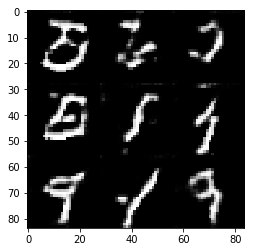

Epoch 2/2... Discriminator Loss: 0.9927... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 1.0076... Generator Loss: 1.5248
Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 1.6113
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.9655
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.5859
Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 1.5746
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 1.3688
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 1.1606


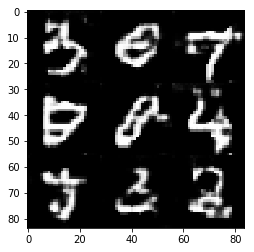

Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.3025
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.1965
Epoch 2/2... Discriminator Loss: 1.1011... Generator Loss: 1.2791
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.3659
Epoch 2/2... Discriminator Loss: 1.0107... Generator Loss: 1.4804
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 1.4123
Epoch 2/2... Discriminator Loss: 0.9480... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 1.5766
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 1.3261
Epoch 2/2... Discriminator Loss: 1.0320... Generator Loss: 0.9887


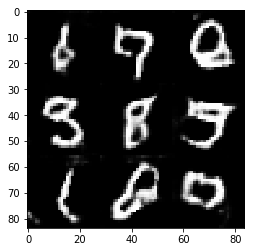

Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.2799
Epoch 2/2... Discriminator Loss: 0.9860... Generator Loss: 1.5262
Epoch 2/2... Discriminator Loss: 1.0610... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 0.9453... Generator Loss: 1.3068
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 1.0860... Generator Loss: 0.9668
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 1.2579
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 1.2253
Epoch 2/2... Discriminator Loss: 0.9604... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 1.1707


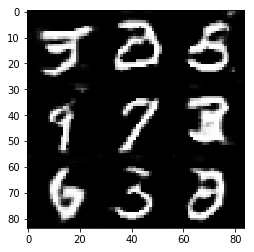

Epoch 2/2... Discriminator Loss: 1.0010... Generator Loss: 1.1047
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.3160
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 1.4694
Epoch 2/2... Discriminator Loss: 0.9305... Generator Loss: 1.9321
Epoch 2/2... Discriminator Loss: 0.9614... Generator Loss: 1.6218
Epoch 2/2... Discriminator Loss: 0.9486... Generator Loss: 1.9148
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.2406
Epoch 2/2... Discriminator Loss: 1.0013... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 0.9310... Generator Loss: 1.7173
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.4183


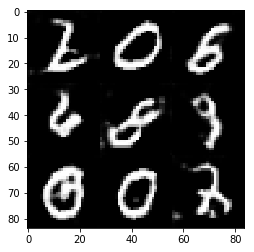

Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.4721
Epoch 2/2... Discriminator Loss: 0.9009... Generator Loss: 1.8708
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 1.9302
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 1.7035
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 1.9001
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 1.4843
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 1.7511
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 1.6965


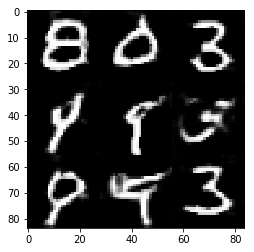

Epoch 2/2... Discriminator Loss: 0.8841... Generator Loss: 1.7864
Epoch 2/2... Discriminator Loss: 0.9524... Generator Loss: 1.5995
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 1.4578
Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.9140
Epoch 2/2... Discriminator Loss: 0.9984... Generator Loss: 1.7889
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 2.1586
Epoch 2/2... Discriminator Loss: 0.9152... Generator Loss: 1.6743
Epoch 2/2... Discriminator Loss: 0.8805... Generator Loss: 1.8494
Epoch 2/2... Discriminator Loss: 0.8449... Generator Loss: 1.7069


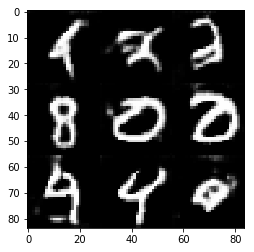

Epoch 2/2... Discriminator Loss: 0.7961... Generator Loss: 1.8939
Epoch 2/2... Discriminator Loss: 0.9273... Generator Loss: 1.5502
Epoch 2/2... Discriminator Loss: 0.8356... Generator Loss: 1.5489
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.8101
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 1.8773
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 1.9779
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.9239
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 1.5858
Epoch 2/2... Discriminator Loss: 0.8662... Generator Loss: 1.6356
Epoch 2/2... Discriminator Loss: 0.8347... Generator Loss: 1.8926


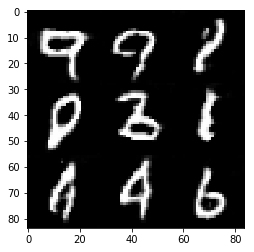

Epoch 2/2... Discriminator Loss: 0.8672... Generator Loss: 1.5873
Epoch 2/2... Discriminator Loss: 0.9466... Generator Loss: 1.4252
Epoch 2/2... Discriminator Loss: 0.8970... Generator Loss: 1.3879
Epoch 2/2... Discriminator Loss: 0.8758... Generator Loss: 1.5545
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.7045
Epoch 2/2... Discriminator Loss: 0.8533... Generator Loss: 1.7239
Epoch 2/2... Discriminator Loss: 0.8829... Generator Loss: 1.5260
Epoch 2/2... Discriminator Loss: 0.8470... Generator Loss: 1.8351
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.7550
Epoch 2/2... Discriminator Loss: 0.8532... Generator Loss: 1.8630


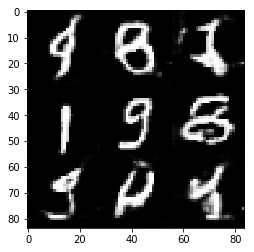

Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 1.6364
Epoch 2/2... Discriminator Loss: 0.8680... Generator Loss: 1.5599
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.8511
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 2.4213
Epoch 2/2... Discriminator Loss: 0.9007... Generator Loss: 2.1380
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 2.1117
Epoch 2/2... Discriminator Loss: 0.7926... Generator Loss: 1.7903
Epoch 2/2... Discriminator Loss: 0.8339... Generator Loss: 1.8226
Epoch 2/2... Discriminator Loss: 0.8069... Generator Loss: 1.5154
Epoch 2/2... Discriminator Loss: 0.7926... Generator Loss: 2.0758


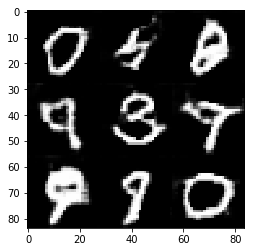

Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.6481
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.6238
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 2.2380
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 2.4089
Epoch 2/2... Discriminator Loss: 0.8900... Generator Loss: 2.2512
Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 2.3124
Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 2.1450
Epoch 2/2... Discriminator Loss: 0.8363... Generator Loss: 1.8619
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 2.1097
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 2.4423


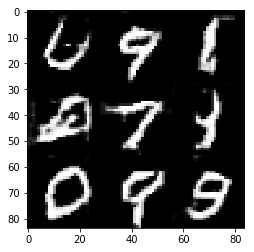

Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 2.2983
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 2.1298
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.4558
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.6662
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 1.8458
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 2.3813
Epoch 2/2... Discriminator Loss: 0.8325... Generator Loss: 2.1254
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 2.0797
Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 2.0793
Epoch 2/2... Discriminator Loss: 0.7796... Generator Loss: 2.3805


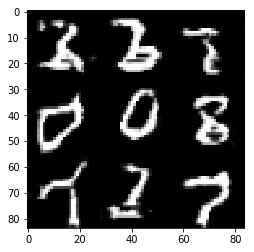

Epoch 2/2... Discriminator Loss: 0.8236... Generator Loss: 2.1958
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.9214
Epoch 2/2... Discriminator Loss: 0.8143... Generator Loss: 1.7822
Epoch 2/2... Discriminator Loss: 0.8736... Generator Loss: 2.2901
Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 2.3499
Epoch 2/2... Discriminator Loss: 0.8447... Generator Loss: 1.8750
Epoch 2/2... Discriminator Loss: 0.8045... Generator Loss: 2.3866
Epoch 2/2... Discriminator Loss: 0.8157... Generator Loss: 1.7657
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.9763
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 1.6765


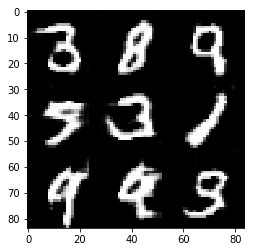

Epoch 2/2... Discriminator Loss: 0.7923... Generator Loss: 2.4190
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 2.1210
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 2.0180
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 2.1016
Epoch 2/2... Discriminator Loss: 0.8085... Generator Loss: 1.9801


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 1.3514
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.7399
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 1.6830
Epoch 1/1... Discriminator Loss: 0.9297... Generator Loss: 2.1978
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 2.4246
Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 2.0655
Epoch 1/1... Discriminator Loss: 0.9927... Generator Loss: 1.6911
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 2.3463
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 2.7084


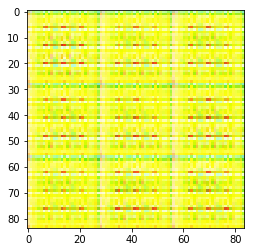

Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 2.8509
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 3.3478
Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 2.0176
Epoch 1/1... Discriminator Loss: 0.9507... Generator Loss: 2.6662
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 1.6055
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 1.4599
Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.7374
Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 1.9291
Epoch 1/1... Discriminator Loss: 1.6164... Generator Loss: 1.5694
Epoch 1/1... Discriminator Loss: 0.9676... Generator Loss: 1.9803


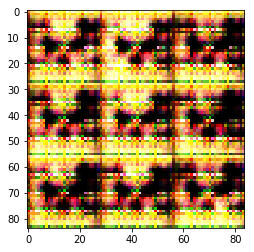

Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.9866
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 1.8593
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 1.9410
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 2.2303
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 2.2378
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 1.8239
Epoch 1/1... Discriminator Loss: 1.4495... Generator Loss: 1.6905
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 1.2019
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 1.6158


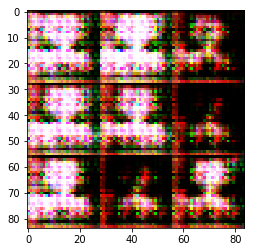

Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.4564
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 1.8676
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 1.8332
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 1.5641
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 1.6075
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 1.4497
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.7962
Epoch 1/1... Discriminator Loss: 0.9667... Generator Loss: 1.6724
Epoch 1/1... Discriminator Loss: 1.0385... Generator Loss: 1.4238


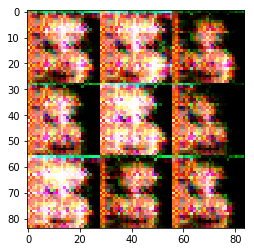

Epoch 1/1... Discriminator Loss: 0.9571... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.8073
Epoch 1/1... Discriminator Loss: 0.9857... Generator Loss: 1.7646
Epoch 1/1... Discriminator Loss: 0.9257... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 0.9233... Generator Loss: 2.0368
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 2.2209
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.7141
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.5974
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.8367


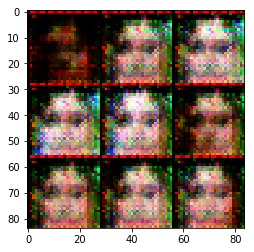

Epoch 1/1... Discriminator Loss: 0.9542... Generator Loss: 2.0109
Epoch 1/1... Discriminator Loss: 0.8593... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.5687
Epoch 1/1... Discriminator Loss: 0.9248... Generator Loss: 1.7531
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 2.1275
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 2.1559
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 2.0716
Epoch 1/1... Discriminator Loss: 0.8610... Generator Loss: 2.2981
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 3.2630
Epoch 1/1... Discriminator Loss: 0.9025... Generator Loss: 2.1919


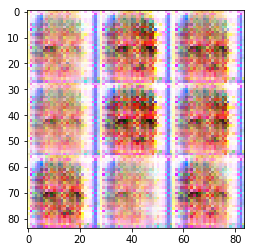

Epoch 1/1... Discriminator Loss: 0.9597... Generator Loss: 1.9692
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 2.1942
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.3520
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 1.3593
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 2.0805
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 1.9197
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.9472


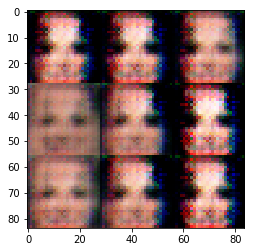

Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 1.8433
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 1.3086
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 1.4134
Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 3.0292
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 1.7056... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 1.7576... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.1817... Generator Loss: 1.2994


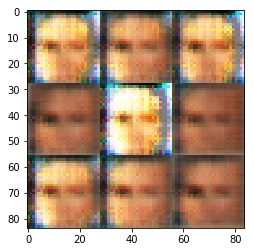

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 2.0894
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 1.1380
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 1.3096
Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.2317
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 1.1604
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 1.0670
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.5128


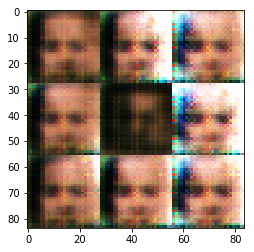

Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.4613
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 1.7913
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 1.3364
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 1.0502
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 1.2074
Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 1.7095
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 1.1350


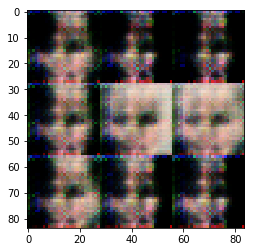

Epoch 1/1... Discriminator Loss: 1.7968... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 1.7683... Generator Loss: 0.8985
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.7150... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 1.0901


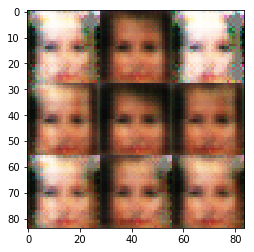

Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.8114... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 2.1008... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.8858
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.9448


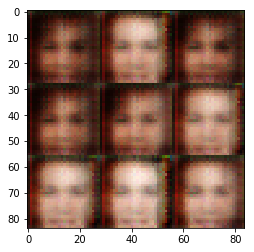

Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.5841... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.6217... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.2557


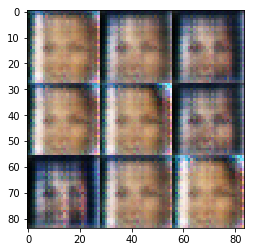

Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.7776... Generator Loss: 0.9669
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.8772
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 1.1220
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 1.0707


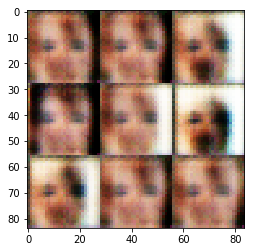

Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 1.0610
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.6550... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.6322... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.5139... Generator Loss: 0.7312


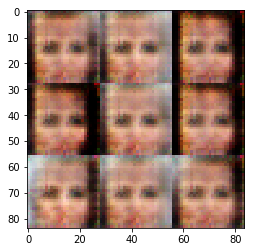

Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 1.0823
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.9998
Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.7678... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.9652


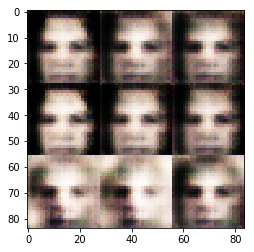

Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.9346
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 1.4615... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.7326
Epoch 1/1... Discriminator Loss: 1.5113... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7935


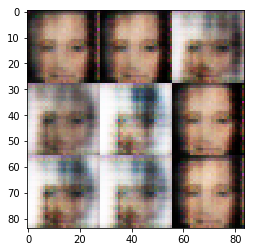

Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.6863... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 1.0393
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 1.0299
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 1.0561


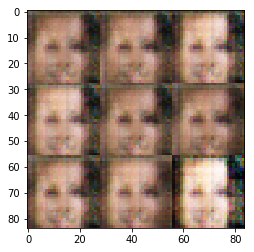

Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.7507... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 1.0334
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 1.2408
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.9011


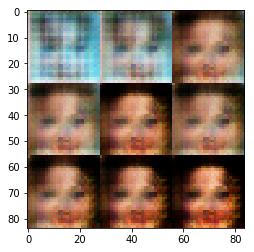

Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.9814
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.0332
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8257


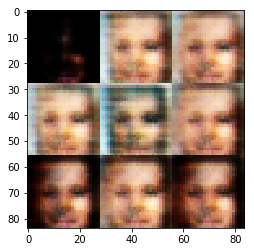

Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4937... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.6363... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.9439


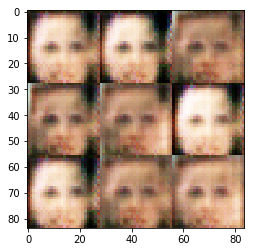

Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8265
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9140
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.9963
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.5220... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.5444... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.6307... Generator Loss: 0.9131


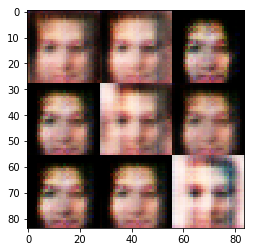

Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.1351... Generator Loss: 1.1629
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.5685... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.9500


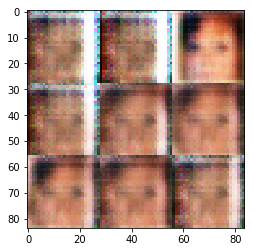

Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.6101... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.9622
Epoch 1/1... Discriminator Loss: 1.6595... Generator Loss: 0.6216


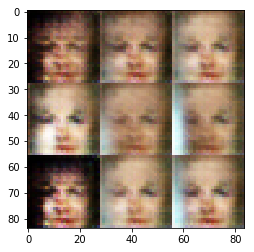

Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.7180... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.6914... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.9068


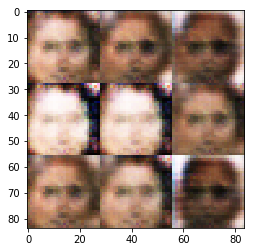

Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.7333... Generator Loss: 0.7269
Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.5568... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7427


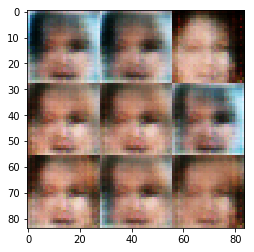

Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.7791
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.6119


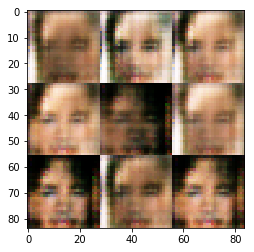

Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.5606... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.5338... Generator Loss: 0.7432


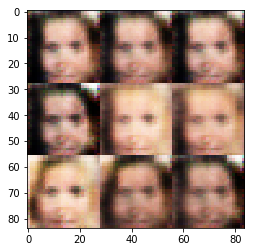

Epoch 1/1... Discriminator Loss: 1.6206... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.5999... Generator Loss: 0.8809


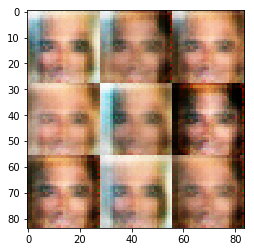

Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.6987... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.5706... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.7372... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.8111... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.8323
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8634


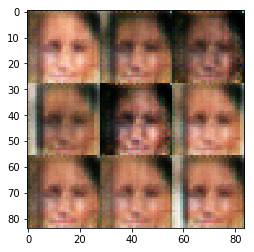

Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.5363... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.8093
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7211


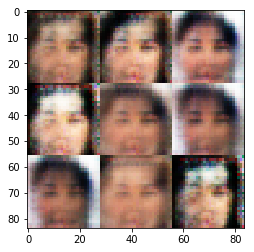

Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.6616


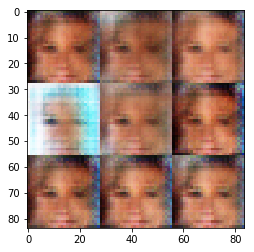

Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6678


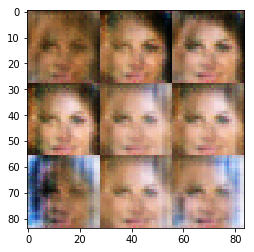

Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4718... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.6426... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.8548
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7804


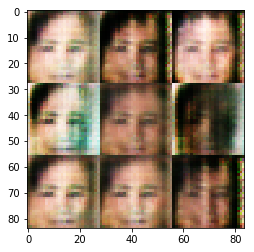

Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.8341
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8091
Epoch 1/1... Discriminator Loss: 1.5145... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.9655


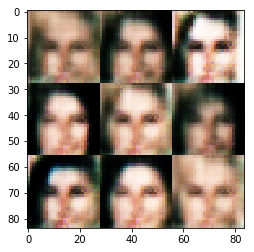

Epoch 1/1... Discriminator Loss: 1.4336... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.6397... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.5240... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.7128


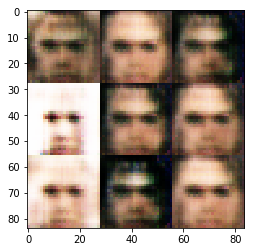

Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 0.9326
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.5060... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.5143... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.7044


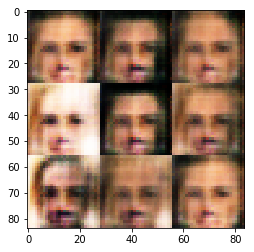

Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.6031... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.6394... Generator Loss: 0.7269


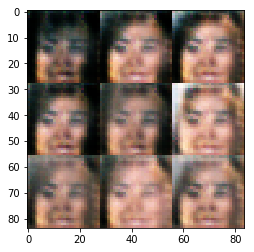

Epoch 1/1... Discriminator Loss: 1.5698... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.6808... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7226


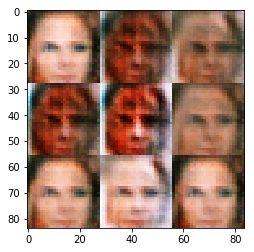

Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.5936... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.5177... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.6087... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.6389... Generator Loss: 0.7160


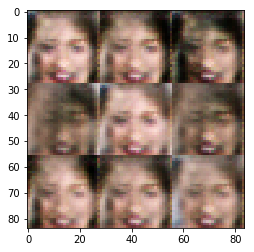

Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.6862... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.7159


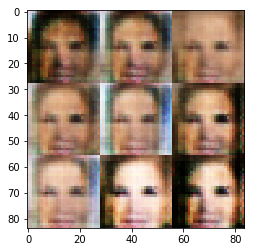

Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.8285
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.5241... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.7067


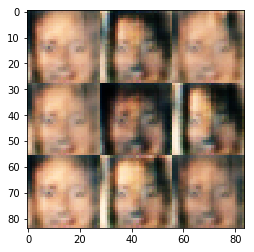

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.7049... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.6804
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7598


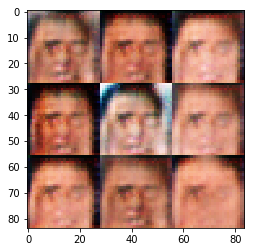

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.5777... Generator Loss: 0.7088
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.6137... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.6312... Generator Loss: 0.7695


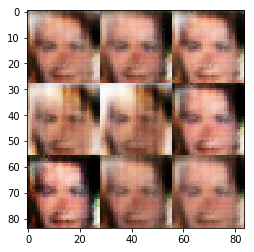

Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.9101
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.6005... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.5399... Generator Loss: 0.6512


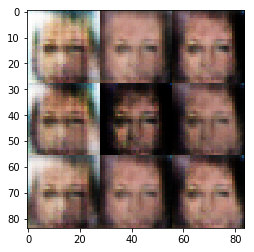

Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 1.0000
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.8266


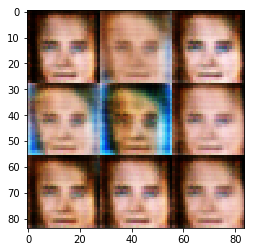

Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.5066... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.5224... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4440... Generator Loss: 0.7199


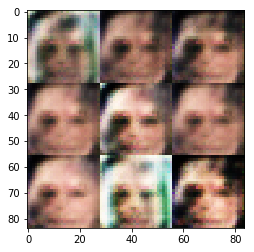

Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.5128... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7727


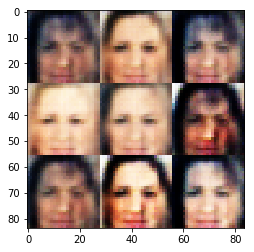

Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.5733


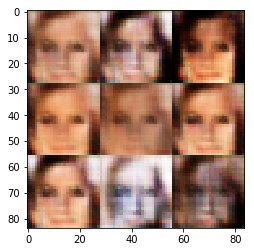

Epoch 1/1... Discriminator Loss: 1.6878... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.5900... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.6594... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7182


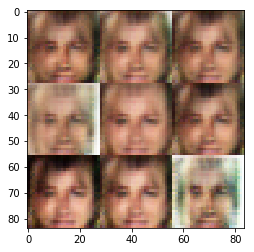

Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.5198... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.7275


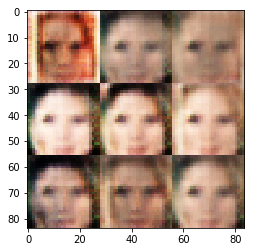

Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6438
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7419


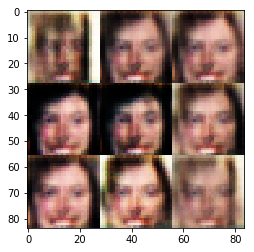

Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.5434... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7710


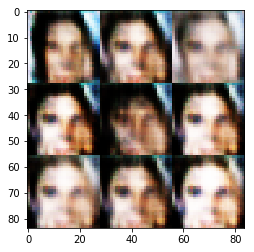

Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.5492... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7247


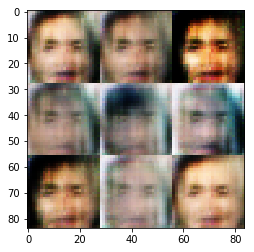

Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.5814... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.7769
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.8293


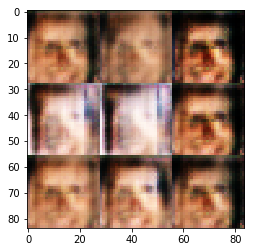

Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.5230... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.5249... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.5658... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.7229


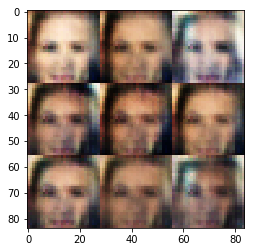

Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7153


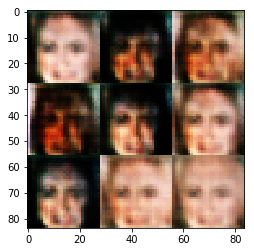

Epoch 1/1... Discriminator Loss: 1.5471... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.5614... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.7191


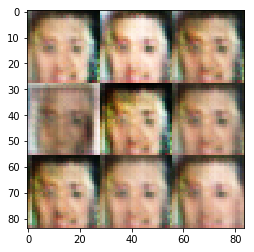

Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.6382... Generator Loss: 0.6374
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8085
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.6722


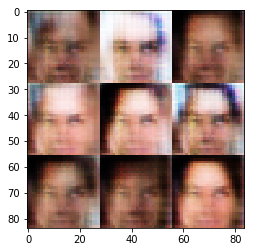

Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4977... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.6940


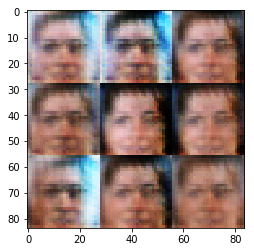

Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6683


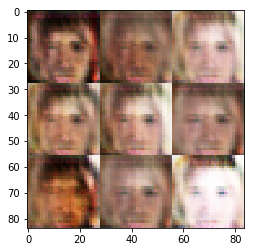

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.7064


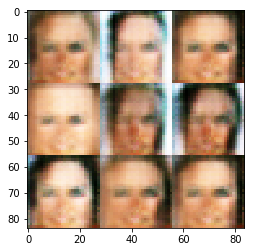

Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7104


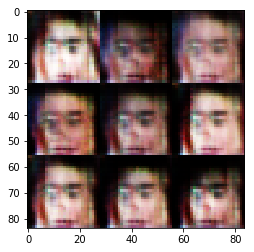

Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8181
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6752


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.